# Cab Fare Prediction


#### Problem Statement​ -
You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected thehistorical data from your pilot project and now have a requirement to apply analytics forfare prediction. You need to design a system that predicts the fare amount for a cab ride in the city.

In [216]:
# loading the required libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from fancyimpute import KNN
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import geodesic
from geopy.distance import great_circle
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.externals import joblib 

In [2]:
# set the working directory
os.chdir('C:/Users/admin/Documents/Python Files')
os.getcwd()

'C:\\Users\\admin\\Documents\\Python Files'

The details of data attributes in the dataset are as follows:
-  pickup_datetime - timestamp value indicating when the cab ride started.
-  pickup_longitude - float for longitude coordinate of where the cab ride started.
-  pickup_latitude - float for latitude coordinate of where the cab ride started.
-  dropoff_longitude - float for longitude coordinate of where the cab ride ended.
-  dropoff_latitude - float for latitude coordinate of where the cab ride ended.
-  passenger_count - an integer indicating the number of passengers in the cab ride.

predictive modeling machine learning project can be broken down into below workflow: 
1. Prepare Problem 
a) Load libraries b) Load dataset 
2. Summarize Data a) Descriptive statistics b) Data visualizations 
3. Prepare Data a) Data Cleaning b) Feature Selection c) Data Transforms 
4. Evaluate Algorithms a) Split-out validation dataset b) Test options and evaluation metric c) Spot Check Algorithms d) Compare Algorithms 
5. Improve Accuracy a) Algorithm Tuning b) Ensembles 
6. Finalize Model a) Predictions on validation dataset b) Create standalone model on entire training dataset c) Save model for later use

In [232]:
# Importing data
train = pd.read_csv('train_cab.csv',dtype={'fare_amount':np.float64},na_values={'fare_amount':'430-'})
test = pd.read_csv('test.csv')
data=[train,test]
for i in data:
    i['pickup_datetime']  = pd.to_datetime(i['pickup_datetime'],errors='coerce')
train.head(5)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns, UTC]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.7 KB


In [6]:
test.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null datetime64[ns, UTC]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 464.8 KB


In [8]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [9]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


## EDA - Data type conversion

-  we will convert passenger_count into a categorical variable because passenger_count is not a continuous variable.
-  passenger_count cannot take continous values. and also they are limited in number if its a cab.

In [4]:
cat_var=['passenger_count']
num_var=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

There are lots of missing values and outliers so it is difficult to visualize data.  
  We Will visualize after missing value analysis.

## Removing values which are not within desired range(outlier) depending upon basic understanding of dataset.

1.Fare amount has a negative value, which doesn't make sense. A price amount cannot be -ve and also cannot be 0. So we will remove these fields.

In [23]:
sum(train['fare_amount']<1)

5

In [24]:
train[train['fare_amount']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.90,2010-03-09 23:37:10+00:00,-73.789450,40.643498,-73.788665,40.641952,1.0
2486,-2.50,2015-03-22 05:14:27+00:00,-74.000031,40.720631,-73.999809,40.720539,1.0
2780,0.01,2015-05-01 15:38:41+00:00,-73.939041,40.713963,-73.941673,40.713997,1.0
10002,0.00,2010-02-15 14:26:01+00:00,-73.987115,40.738808,-74.005911,40.713960,1.0
13032,-3.00,2013-08-30 08:57:10+00:00,-73.995062,40.740755,-73.995885,40.741357,4.0


In [4]:
train = train.drop(train[train['fare_amount']<1].index, axis=0)

In [73]:
# train.loc[train['fare_amount'] < 1,'fare_amount'] = np.nan

2.Passenger_count variable

In [79]:
for i in range(4,11):
    print('passenger_count above' +str(i)+'={}'.format(sum(train['passenger_count']>i)))

passenger_count above4=1367
passenger_count above5=322
passenger_count above6=20
passenger_count above7=20
passenger_count above8=20
passenger_count above9=20
passenger_count above10=20


so 20 observations of passenger_count is consistenly above from 6,7,8,9,10 passenger_counts, let's check them.

In [80]:
train[train['passenger_count']>6]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
233,8.5,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0
263,4.9,2010-07-12 09:44:33+00:00,-73.983249,40.734655,-73.991278,40.738918,456.0
293,6.1,2011-01-18 23:48:00+00:00,-74.006642,40.738927,-74.010828,40.717907,5334.0
356,8.5,2013-06-18 10:27:05+00:00,-73.992108,40.764203,-73.973000,40.762695,535.0
386,8.1,2009-08-21 19:35:05+00:00,-73.960853,40.761557,-73.976335,40.748361,354.0
413,NaN,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0
971,10.1,2010-11-21 01:41:00+00:00,-74.004500,40.742143,-73.994330,40.720412,554.0
1007,3.7,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0
1043,5.7,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0
1107,4.9,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0


Also we need to see if there are any passenger_count<1

In [5]:
train[train['passenger_count']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
314,34.0,2015-06-02 23:16:15+00:00,-73.974899,40.751095,-73.908546,40.881878,0.00
566,4.9,2012-01-28 21:33:18+00:00,-73.955322,40.782840,-73.955797,40.773673,0.00
678,6.5,2012-02-27 07:24:20+00:00,-73.983397,40.738183,-73.971395,40.758023,0.00
1160,13.3,2011-05-25 23:58:48+00:00,-73.998360,40.740348,-73.946455,40.777348,0.00
1935,10.1,2011-10-23 11:09:28+00:00,-73.971400,40.795000,-73.967900,40.768600,0.00
2200,8.1,2011-05-23 16:54:19+00:00,-73.988008,40.748303,-74.005185,40.738733,0.00
2425,8.9,2011-11-25 22:47:33+00:00,-73.999900,40.738600,-73.971800,40.746300,0.00
3034,5.7,2011-03-06 12:03:14+00:00,-73.986557,40.745783,-73.994545,40.729995,0.00
3413,7.3,2011-02-28 06:39:16+00:00,-73.973413,40.743708,-73.985220,40.741583,0.00
3481,11.3,2011-11-30 17:23:02+00:00,-73.968100,40.762500,-73.984400,40.760900,0.00


In [6]:
len(train[train['passenger_count']<1])

58

In [84]:
test['passenger_count'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

-  passenger_count variable conatins values which are equal to 0.
-  And test data does not contain passenger_count=0 . So if we feature engineer passenger_count of train dataset then it will create a dummy variable for passenger_count=0 which will be an extra feature compared to test dataset.
-  So, we will remove those 0 values.
-  Also, We will remove 20 observation which are above 6 value because a cab cannot hold these number of passengers.

In [5]:
train = train.drop(train[train['passenger_count']>6].index, axis=0)
train = train.drop(train[train['passenger_count']<1].index, axis=0)

In [31]:
# train.loc[train['passenger_count'] >6,'passenger_count'] = np.nan
# train.loc[train['passenger_count'] >1,'passenger_count'] = np.nan

In [89]:
sum(train['passenger_count']>6)

0

3.Latitudes range from -90 to 90.Longitudes range from -180 to 180.
  Removing which does not satisfy these ranges

In [10]:
print('pickup_longitude above 180={}'.format(sum(train['pickup_longitude']>180)))
print('pickup_longitude below -180={}'.format(sum(train['pickup_longitude']<-180)))
print('pickup_latitude above 90={}'.format(sum(train['pickup_latitude']>90)))
print('pickup_latitude below -90={}'.format(sum(train['pickup_latitude']<-90)))
print('dropoff_longitude above 180={}'.format(sum(train['dropoff_longitude']>180)))
print('dropoff_longitude below -180={}'.format(sum(train['dropoff_longitude']<-180)))
print('dropoff_latitude below -90={}'.format(sum(train['dropoff_latitude']<-90)))
print('dropoff_latitude above 90={}'.format(sum(train['dropoff_latitude']>90)))

pickup_longitude above 180=0
pickup_longitude below -180=0
pickup_latitude above 90=1
pickup_latitude below -90=0
dropoff_longitude above 180=0
dropoff_longitude below -180=0
dropoff_latitude below -90=0
dropoff_latitude above 90=0


-  There's only one outlier which is in variable pickup_latitude.So we will remove it with nan.
-  Also we will see if there are any values equal to 0.

In [11]:
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    print(i,'equal to 0={}'.format(sum(train[i]==0)))

pickup_longitude equal to 0=315
pickup_latitude equal to 0=315
dropoff_longitude equal to 0=314
dropoff_latitude equal to 0=312


there are values which are equal to 0. we will remove them.

In [6]:
train = train.drop(train[train['pickup_latitude']>90].index, axis=0)
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    train = train.drop(train[train[i]==0].index, axis=0)

In [22]:
# for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
#     train.loc[train[i]==0,i] = np.nan
# train.loc[train['pickup_latitude']>90,'pickup_latitude'] = np.nan

In [7]:
train.shape

(15661, 7)

So, we lossed 16067-15661=406 observations because of non-sensical values.

In [8]:
df=train.copy()
# train=df.copy()

## Missing Value Analysis 

In [8]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(train.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,fare_amount,22
1,pickup_datetime,1
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


-  As we can see there are some missing values in the data.
-  Also pickup_datetime variable has 1 missing value. 
-  We will impute missing values for fare_amount,passenger_count variables except pickup_datetime.
-  And we will drop that 1 row which has missing value in pickup_datetime.

In [9]:
#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})
missing_val
#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(train))*100
#descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_val

,Variables,Missing_percentage
0,passenger_count,0.351191
1,fare_amount,0.140476
2,pickup_datetime,0.006385
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


1.For Passenger_count:
-  Actual value = 1
-  Mode = 1
-  KNN = 2

In [97]:
# Choosing a random values to replace it as NA
train['passenger_count'].loc[1000]

1.0

In [98]:
# Replacing 1.0 with NA
train['passenger_count'].loc[1000] = np.nan
train['passenger_count'].loc[1000]

nan

In [99]:
# Impute with mode
train['passenger_count'].fillna(train['passenger_count'].mode()[0]).loc[1000]

1.0

We can't use mode method because data will be more biased towards passenger_count=1

2.For fare_amount: 
-  Actual value = 7.0,
-  Mean = 15.117,
-  Median = 8.5,
-  KNN = 7.369801

In [100]:
# for i in ['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
#     # Choosing a random values to replace it as NA
#     a=train[i].loc[1000]
#     print(i,'at loc-1000:{}'.format(a))
#     # Replacing 1.0 with NA
#     train[i].loc[1000] = np.nan
#     print('Value after replacing with nan:{}'.format(train[i].loc[1000]))
#     # Impute with mean
#     print('Value if imputed with mean:{}'.format(train[i].fillna(train[i].mean()).loc[1000]))
#     # Impute with median
#     print('Value if imputed with median:{}\n'.format(train[i].fillna(train[i].median()).loc[1000]))

In [101]:
# Choosing a random values to replace it as NA
a=train['fare_amount'].loc[1000]
print('fare_amount at loc-1000:{}'.format(a))
# Replacing 1.0 with NA
train['fare_amount'].loc[1000] = np.nan
print('Value after replacing with nan:{}'.format(train['fare_amount'].loc[1000]))
# Impute with mean
print('Value if imputed with mean:{}'.format(train['fare_amount'].fillna(train['fare_amount'].mean()).loc[1000]))
# Impute with median
print('Value if imputed with median:{}'.format(train['fare_amount'].fillna(train['fare_amount'].median()).loc[1000]))

fare_amount at loc-1000:7.0
Value after replacing with nan:nan
Value if imputed with mean:15.117964703625402
Value if imputed with median:8.5


In [102]:
train.std()

fare_amount          435.968232
pickup_longitude       2.658966
pickup_latitude        2.613222
dropoff_longitude      2.710749
dropoff_latitude       2.632316
passenger_count        1.266115
dtype: float64

In [9]:
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']

we will separate pickup_datetime into a different dataframe and then merge with train in feature engineering step.

In [10]:
pickup_datetime=pd.DataFrame(train['pickup_datetime'])

In [11]:
# Imputing with missing values using KNN
# Use 19 nearest rows which have a feature to fill in each row's missing features
train = pd.DataFrame(KNN(k = 19).fit_transform(train.drop('pickup_datetime',axis=1)),columns=columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 54.685
Imputing row 101/15661 with 0 missing, elapsed time: 56.473
Imputing row 201/15661 with 0 missing, elapsed time: 56.492
Imputing row 301/15661 with 0 missing, elapsed time: 56.688
Imputing row 401/15661 with 0 missing, elapsed time: 56.759
Imputing row 501/15661 with 0 missing, elapsed time: 56.765
Imputing row 601/15661 with 0 missing, elapsed time: 56.776
Imputing row 701/15661 with 0 missing, elapsed time: 56.785
Imputing row 801/15661 with 0 missing, elapsed time: 56.798
Imputing row 901/15661 with 0 missing, elapsed time: 56.811
Imputing row 1001/15661 with 0 missing, elapsed time: 56.813
Imputing row 1101/15661 with 0 missing, elapsed time: 56.814
Imputing row 1201/15661 with 0 missing, elapsed time: 56.815
Imputing row 1301/15661 with 0 missing, elapsed time: 56.816
Imputing row 1401/15661 with 0 missing, elapsed time: 56.819
Imputing row 1501/15661 with 0 missing, elapsed time: 56.821
Imputing row 1601/15661 with 0 missi

In [12]:
train.std()

fare_amount          435.661995
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264129
dtype: float64

In [12]:
train.loc[1000]

fare_amount           7.000000
pickup_longitude    -73.995420
pickup_latitude      40.759662
dropoff_longitude   -73.987607
dropoff_latitude     40.751247
passenger_count       1.000000
Name: 1000, dtype: float64

In [30]:
train['passenger_count'].head()

0    1.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: passenger_count, dtype: float64

In [13]:
train['passenger_count']=train['passenger_count'].astype('int')

In [32]:
train.std()

fare_amount          431.240841
pickup_longitude       2.633492
pickup_latitude        2.587517
dropoff_longitude      2.684717
dropoff_latitude       2.606464
passenger_count        1.264446
dtype: float64

In [14]:
train['passenger_count'].unique()

array([1, 2, 3, 6, 5, 4], dtype=int64)

In [14]:
train['passenger_count']=train['passenger_count'].round().astype('object').astype('category',ordered=True)

In [13]:
train['passenger_count'].unique()

[1, 2, 3, 6, 5, 4]
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [15]:
train.loc[1000]

fare_amount                7
pickup_longitude    -73.9954
pickup_latitude      40.7597
dropoff_longitude   -73.9876
dropoff_latitude     40.7512
passenger_count            1
Name: 1000, dtype: object

-  Now about missing value in pickup_datetime

In [143]:
pickup_datetime.head()

,pickup_datetime
0,2009-06-15 17:26:21+00:00
1,2010-01-05 16:52:16+00:00
2,2011-08-18 00:35:00+00:00
3,2012-04-21 04:30:42+00:00
4,2010-03-09 07:51:00+00:00


In [144]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(pickup_datetime.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,pickup_datetime,1


In [15]:
pickup_datetime.shape

(15661, 1)

In [16]:
train.shape

(15661, 6)

-  We will drop 1 row which has missing value for pickup_datetime variable after feature engineering step because if we drop now, pickup_datetime dataframe will have 16040 rows and our train has 1641 rows, then if we merge these 2 dataframes then pickup_datetime variable will gain 1 missing value.
-  And if we merge and then drop now then we would require to split again before outlier analysis and then merge again in feature engineering step.
-  So, instead of doing the work 2 times we will drop 1 time i.e. after feature engineering process.

In [15]:
df1 = train.copy()
# train=df1.copy()

In [17]:
train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11057
Name: passenger_count, dtype: int64

In [15]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15.110645,-73.911514,40.689712,-73.906315,40.687655
std,435.661995,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.500000,-73.982049,40.753300,-73.980555,40.754242
75%,12.500000,-73.968080,40.767805,-73.965360,40.768312
max,54343.000000,40.766125,41.366138,40.802437,41.366138


## Outlier Analysis using Boxplot
-  We Will do Outlier Analysis only on Fare_amount just for now and we will do outlier analysis after feature engineering laitudes and longitudes.

In [16]:
# setting up the sns for plots
sns.set(style='darkgrid',palette='Set1')

-  Univariate Boxplots: Boxplots for all Numerical Variables including target variable.

In [ ]:
# for i in train['fare_amount']:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient='h')
plt.title('Boxplot of ')
#     plt.savefig('bp'+str(i)+'.png')
plt.show()

In [95]:
# sum(train['fare_amount']<22.5)/len(train['fare_amount'])*100

91.30461883687589

-  Bivariate Boxplots: Boxplot for Numerical Variable Vs Categorical Variable.

In [ ]:
plt.figure(figsize=(20,10))
plt.xlim(0,100)
_ = sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of w.r.t')
#         plt.savefig('Boxplot of '+str(b)+' w.r.t '+str(a)+'.png')
plt.show()

In [80]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,great_circle,geodesic
count,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000,15983.000000
mean,9.388783,-73.911852,40.690306,-73.906691,40.688149,2.481506,2.481510,2.481970
std,4.467208,2.633575,2.587598,2.684801,2.606545,34.572677,34.572725,34.569407
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000,0.000000,0.000000
25%,6.000000,-73.992180,40.736957,-73.991182,40.736758,0.760248,0.760304,0.760099
50%,8.100000,-73.981947,40.753300,-73.980411,40.754153,1.326006,1.325902,1.326243
75%,11.700000,-73.968232,40.767485,-73.965529,40.768090,2.394143,2.394334,2.395560
max,22.100000,40.766125,41.366138,40.802437,41.366138,3368.446398,3368.451131,3377.012556


In [38]:
train['passenger_count'].describe()

count     16043
unique        7
top           1
freq      11298
Name: passenger_count, dtype: int64

## Outlier Treatment
-  As we can see from the above Boxplots there are outliers in the train dataset.
-  Reconsider pickup_longitude,etc.

In [17]:
def outlier_treatment(col):
    ''' calculating outlier indices and replacing them with NA  '''
    #Extract quartiles
    q75, q25 = np.percentile(train[col], [75 ,25])
    print(q75,q25)
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(minimum,maximum)
    #Replace with NA
    train.loc[train[col] < minimum,col] = np.nan
    train.loc[train[col] > maximum,col] = np.nan

In [18]:
# for i in num_var:
    outlier_treatment('fare_amount')
#     outlier_treatment('pickup_longitude')
#     outlier_treatment('pickup_latitude')
#     outlier_treatment('dropoff_longitude')
#     outlier_treatment('dropoff_latitude')

12.5 6.0
-3.75 22.25


In [19]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,1359
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [20]:
train.std()

fare_amount          4.136113
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264329
dtype: float64

In [21]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 46.518
Imputing row 101/15661 with 0 missing, elapsed time: 46.523
Imputing row 201/15661 with 0 missing, elapsed time: 46.529
Imputing row 301/15661 with 1 missing, elapsed time: 46.533
Imputing row 401/15661 with 0 missing, elapsed time: 46.537
Imputing row 501/15661 with 0 missing, elapsed time: 46.541
Imputing row 601/15661 with 1 missing, elapsed time: 46.546
Imputing row 701/15661 with 0 missing, elapsed time: 46.550
Imputing row 801/15661 with 0 missing, elapsed time: 46.553
Imputing row 901/15661 with 0 missing, elapsed time: 46.557
Imputing row 1001/15661 with 0 missing, elapsed time: 46.559
Imputing row 1101/15661 with 1 missing, elapsed time: 46.564
Imputing row 1201/15661 with 0 missing, elapsed time: 46.567
Imputing row 1301/15661 with 0 missing, elapsed time: 46.570
Imputing row 1401/15661 with 0 missing, elapsed time: 46.574
Imputing row 1501/15661 with 0 missing, elapsed time: 46.581
Imputing row 1601/15661 with 0 missi

In [38]:
train.std()

fare_amount          4.476982
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264329
dtype: float64

In [26]:
train['passenger_count'].describe()

count    15661.000000
mean         1.649128
std          1.264329
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [22]:
train['passenger_count']=train['passenger_count'].astype('int').round().astype('object').astype('category')

In [58]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000
mean,9.388915,-73.911856,40.690308,-73.906696,40.688153
std,4.467099,2.633492,2.587517,2.684717,2.606464
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992179,40.736957,-73.991182,40.736759
50%,8.100000,-73.981947,40.753300,-73.980413,40.754154
75%,11.700000,-73.968232,40.767484,-73.965530,40.768089
max,22.100000,40.766125,41.366138,40.802437,41.366138


In [59]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [146]:
# df2 = train.copy()
train=df2.copy()

In [24]:
train.shape

(15661, 6)

https://www.neuraldesigner.com/blog/3_methods_to_deal_with_outliers

## Graphical EDA - Data Visualization 

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim(0,100)
sns.violinplot(y='fare_amount',data=train)

In [ ]:
sns.countplot(x='passenger_count' ,data=train)

## Feature Engineering

#### 1.Feature Engineering for timestamp variable
-  we will derive new features from pickup_datetime variable
-  new features will be year,month,day_of_week,hour

In [147]:
# we will Join 2 Dataframes pickup_datetime and train
train = pd.merge(pickup_datetime,train,right_index=True,left_index=True)
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [148]:
train.shape

(15661, 7)

In [149]:
train=train.reset_index(drop=True)

As we discussed in Missing value imputation step about dropping missing value, we will do it now.

In [150]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,1
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [151]:
train=train.dropna()

In [152]:
data = [train,test]
for i in data:
    i["year"] = i["pickup_datetime"].apply(lambda row: row.year)
    i["month"] = i["pickup_datetime"].apply(lambda row: row.month)
#     i["day_of_month"] = i["pickup_datetime"].apply(lambda row: row.day)
    i["day_of_week"] = i["pickup_datetime"].apply(lambda row: row.dayofweek)
    i["hour"] = i["pickup_datetime"].apply(lambda row: row.hour)

In [140]:
train_nodummies=train.copy()
# train=train_nodummies.copy()

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(train['year'])

plt.figure(figsize=(20,10))
sns.countplot(train['month'])

plt.figure(figsize=(20,10))
sns.countplot(train['day_of_week'])

plt.figure(figsize=(20,10))
sns.countplot(train['hour'])

Now we will use month,day_of_week,hour to derive new features like sessions in a day,seasons in a year,week:weekend/weekday

In [153]:
def f(x):
    ''' for sessions in a day using hour column '''
    if (x >=5) and (x <= 11):
        return 'morning'
    elif (x >=12) and (x <=16 ):
        return 'afternoon'
    elif (x >= 17) and (x <= 20):
        return'evening'
    elif (x >=21) and (x <= 23) :
        return 'night_PM'
    elif (x >=0) and (x <=4):
        return'night_AM'

In [154]:
def g(x):
    ''' for seasons in a year using month column'''
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

In [155]:
def h(x):
    ''' for week:weekday/weekend in a day_of_week column '''
    if (x >=0) and (x <= 4):
        return 'weekday'
    elif (x >=5) and (x <=6 ):
        return 'weekend'

In [156]:
train['session'] = train['hour'].apply(f)
test['session'] = test['hour'].apply(f)
# train_nodummies['session'] = train_nodummies['hour'].apply(f)

In [157]:
train['seasons'] = train['month'].apply(g)
test['seasons'] = test['month'].apply(g)
# train['seasons'] = test['month'].apply(g)

In [158]:
train['week'] = train['day_of_week'].apply(h)
test['week'] = test['day_of_week'].apply(h)

In [159]:
train.shape

(15660, 14)

In [160]:
test.shape

(9914, 13)

#### 2.Feature Engineering for passenger_count variable
- Because models in scikit learn require numerical input,if dataset contains categorical variables then we have to encode them.
- We will use one hot encoding technique for passenger_count variable.

In [149]:
train['passenger_count'].describe()

count     15660
unique        6
top           1
freq      11031
Name: passenger_count, dtype: int64

In [161]:
#Creating dummies for each variable in passenger_count and merging dummies dataframe to both train and test dataframe
temp = pd.get_dummies(train['passenger_count'], prefix = 'passenger_count')
train = train.join(temp)
temp = pd.get_dummies(test['passenger_count'], prefix = 'passenger_count')
test = test.join(temp)
temp = pd.get_dummies(train['seasons'], prefix = 'season')
train = train.join(temp)
temp = pd.get_dummies(test['seasons'], prefix = 'season')
test = test.join(temp)
temp = pd.get_dummies(train['week'], prefix = 'week')
train = train.join(temp)
temp = pd.get_dummies(test['week'], prefix = 'week')
test = test.join(temp)
temp = pd.get_dummies(train['session'], prefix = 'session')
train = train.join(temp)
temp = pd.get_dummies(test['session'], prefix = 'session')
test = test.join(temp)
temp = pd.get_dummies(train['year'], prefix = 'year')
train = train.join(temp)
temp = pd.get_dummies(test['year'], prefix = 'year')
test = test.join(temp)

In [162]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,0,0,1,0,0,0,0,0,0
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,0,0,1,0,0,0,0,0
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,1,0,0,0,1,0,0,0,0
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,1,0,0,0,0,1,0,0,0
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,1,0,0,0,1,0,0,0,0,0


In [163]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_morning,session_night_AM,session_night_PM,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,1,0,0,0,0,1,0,0,0,0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0


we will drop one column from each one-hot-encoded variables

In [164]:
train.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2009',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2015'],
      dtype='object')

In [166]:
train=train.drop(['passenger_count_1','season_fall','week_weekday','session_afternoon','year_2009'],axis=1)
test=test.drop(['passenger_count_1','season_fall','week_weekday','session_afternoon','year_2009'],axis=1)

#### 3.Feature Engineering for latitude and longitude variable
-  As we have latitude and longitude data for pickup and dropoff, we will find the distance the cab travelled from pickup and dropoff location.

In [ ]:
# train.sort_values('pickup_datetime')

In [36]:
# def haversine(coord1, coord2):
#     '''Calculate distance the cab travelled from pickup and dropoff location using the Haversine Formula'''
#     data = [train, test]
#     for i in data:
#         lon1, lat1 = coord1
#         lon2, lat2 = coord2
#         R = 6371000  # radius of Earth in meters
#         phi_1 = np.radians(i[lat1])
#         phi_2 = np.radians(i[lat2])
#         delta_phi = np.radians(i[lat2] - i[lat1])
#         delta_lambda = np.radians(i[lon2] - i[lon1])
#         a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2
#         c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         meters = R * c  # output distance in meters
#         km = meters / 1000.0  # output distance in kilometers
#         miles = round(km, 3)/1.609344
#         i['distance'] = miles
# #     print(f"Distance: {miles} miles")
# #     return miles

In [37]:
# haversine(['pickup_longitude','pickup_latitude'],['dropoff_longitude','dropoff_latitude'])

https://pypi.org/project/geopy/

https://www.quora.com/What-is-the-best-way-to-treat-longitude-latitude-features-in-a-machine-learning-predictive-model

https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula

https://geopy.readthedocs.io/en/latest/#module-geopy.distance

https://stackoverflow.com/questions/38248046/is-the-haversine-formula-or-the-vincentys-formula-better-for-calculating-distan

In [167]:
# Calculate distance the cab travelled from pickup and dropoff location using great_circle from geopy library
data = [train, test]
for i in data:
    i['great_circle']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)
    i['geodesic']=i.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)

In [168]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,0,0,0,0,0,0,0,0,0.640488,0.639764
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,1,0,0,0,0,0,5.250677,5.246511
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,1,0,0,1,0,0,0,0,0.863412,0.863167
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,1,0,0,0,1,0,0,0,1.739388,1.737223
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,0,0,1,0,0,0,0,0,1.242220,1.241710


In [169]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.443609,1.442197
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,1,1.507047,1.506080
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,0,0,0,1,0,0,0,0,0.384398,0.384120
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,1,0,0,1,0,0,0,1.218531,1.217683
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,1,0,0,1,0,0,0,3.347519,3.344737


As Vincenty is more accurate than haversine. Also vincenty is prefered for short distances.Therefore we will drop distance and great_circle. we will drop them together with other variables which were used to feature engineer.

In [170]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,0
month,0
day_of_week,0


In [171]:
pd.DataFrame(test.isna().sum())

,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,0
month,0
day_of_week,0
hour,0


#### We will remove the variables which were used to feature engineer new variables

In [164]:
# train_nodummies=train_nodummies.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
#        'dropoff_longitude', 'dropoff_latitude','great_circle'],axis = 1)
# test_nodummies=test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
#        'dropoff_longitude', 'dropoff_latitude','passenger_count_1', 'passenger_count_2', 'passenger_count_3',
#        'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
#        'season_fall', 'season_spring', 'season_summer', 'season_winter',
#        'week_weekday', 'week_weekend', 'session_afternoon', 'session_evening',
#        'session_morning', 'session_night (AM)', 'session_night (PM)',
#        'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
#        'year_2014', 'year_2015', 'great_circle'],axis = 1)

In [172]:
train=train.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)
test=test.drop(['pickup_datetime','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons', 'week','great_circle'],axis=1)

In [173]:
train.shape,test.shape

((15660, 21), (9914, 20))

In [ ]:
# test_nodummies.columns

In [ ]:
# train_nodummies.columns

In [174]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [175]:
test.columns

Index(['passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'season_spring',
       'season_summer', 'season_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'geodesic'],
      dtype='object')

In [176]:
train.head()

,fare_amount,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_spring,season_summer,season_winter,week_weekend,...,session_morning,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,4.5,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.639764
1,16.9,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,5.246511
2,5.7,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0.863167
3,7.7,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1.737223
4,5.3,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1.241710


In [177]:
test.head()

,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_spring,season_summer,season_winter,week_weekend,session_evening,session_morning,session_night_AM,session_night_PM,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.442197
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1.506080
2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0.384120
3,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1.217683
4,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,3.344737


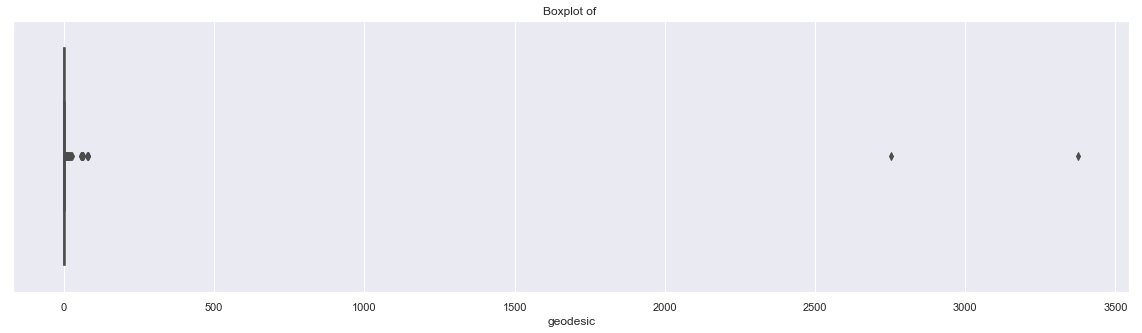

In [30]:
plt.figure(figsize=(20,5)) 
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of ')
#     plt.savefig('bp'+str(i)+'.png')
plt.show()

In [178]:
outlier_treatment('geodesic')

2.425668049965582 0.7815214474966259
-1.6846984562068081 4.891887953669016


In [179]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0
passenger_count_5,0
passenger_count_6,0
season_spring,0
season_summer,0
season_winter,0
week_weekend,0


In [180]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15660 with 0 missing, elapsed time: 94.137
Imputing row 101/15660 with 0 missing, elapsed time: 96.452
Imputing row 201/15660 with 0 missing, elapsed time: 96.459
Imputing row 301/15660 with 1 missing, elapsed time: 96.465
Imputing row 401/15660 with 0 missing, elapsed time: 96.468
Imputing row 501/15660 with 0 missing, elapsed time: 96.480
Imputing row 601/15660 with 1 missing, elapsed time: 96.482
Imputing row 701/15660 with 0 missing, elapsed time: 96.487
Imputing row 801/15660 with 0 missing, elapsed time: 96.492
Imputing row 901/15660 with 0 missing, elapsed time: 96.495
Imputing row 1001/15660 with 0 missing, elapsed time: 96.498
Imputing row 1101/15660 with 1 missing, elapsed time: 96.501
Imputing row 1201/15660 with 0 missing, elapsed time: 96.505
Imputing row 1301/15660 with 0 missing, elapsed time: 96.510
Imputing row 1401/15660 with 0 missing, elapsed time: 96.514
Imputing row 1501/15660 with 0 missing, elapsed time: 96.735
Imputing row 1601/15660 with 0 missi

## Feature Selection
1.Correlation Analysis

    Statistically correlated: features move together directionally.
    Linear models assume feature independence.
    And if features are correlated that could introduce bias into our models.

In [182]:
cat_var=['passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_spring', 'season_summer',
       'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015']
num_var=['fare_amount','geodesic']
train[cat_var]=train[cat_var].apply(lambda x: x.astype('category') )
test[cat_var]=test[cat_var].apply(lambda x: x.astype('category') ) 

-  We will plot a Heatmap of correlation whereas, correlation measures how strongly 2 quantities are related to each other.

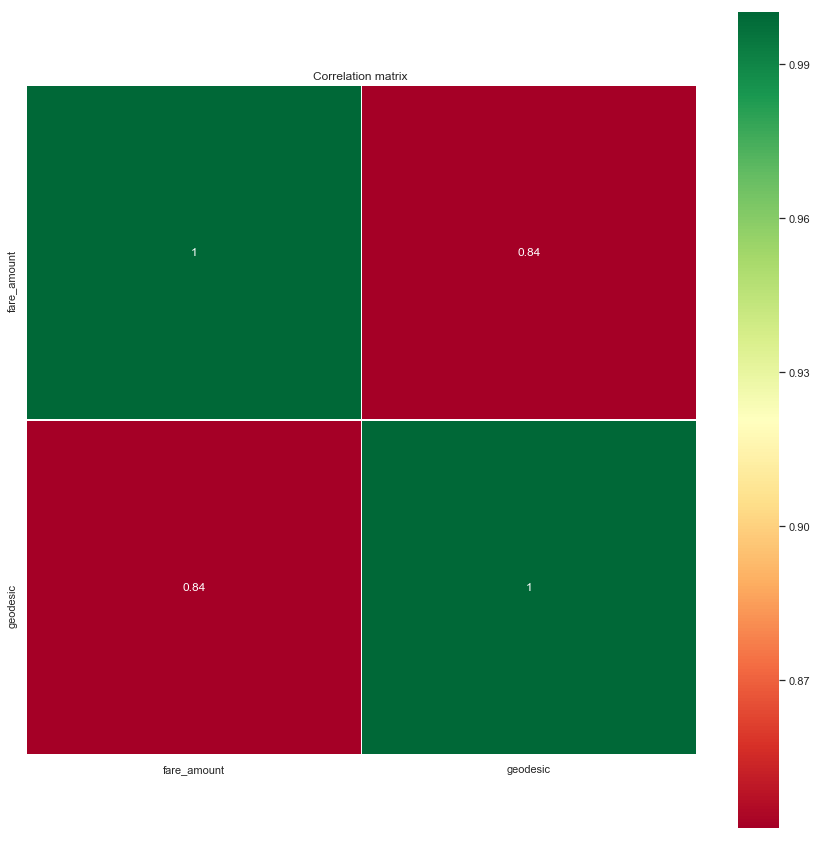

In [183]:
# heatmap using correlation matrix
plt.figure(figsize=(15,15))
_ = sns.heatmap(train[num_var].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')
# plt.savefig('correlation.png')
plt.show()

As we can see from above correlation plot fare_amount and geodesic is correlated to each other.

### Chi-square test of Independence for Categorical Variables/Features

-  Hypothesis testing :
    -  Null Hypothesis: 2 variables are independent.
    -  Alternate Hypothesis: 2 variables are not independent.
-  If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
-  And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent. 
-  There should be no dependencies between Independent variables.
-  So we will remove that variable whose p-value with other variable is low than 0.05.
-  And we will keep that variable whose p-value with other variable is high than 0.05

In [185]:
#loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(train[i], train[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

passenger_count_2 and passenger_count_3 are dependent on each other with 1.7653246997910713e-27 ----Remove
passenger_count_2 and passenger_count_4 are dependent on each other with 1.1757533995567553e-13 ----Remove
passenger_count_2 and passenger_count_5 are dependent on each other with 1.0804166465817462e-42 ----Remove
passenger_count_2 and passenger_count_6 are dependent on each other with 1.0480757938914989e-12 ----Remove
passenger_count_2 and season_spring are independent on each other with 0.9950455671296065 ----Keep
passenger_count_2 and season_summer are dependent on each other with 0.022097928791318253 ----Remove
passenger_count_2 and season_winter are independent on each other with 0.5118293960940499 ----Keep
passenger_count_2 and week_weekend are dependent on each other with 5.984645337594806e-11 ----Remove
passenger_count_2 and session_evening are dependent on each other with 0.01688355267780062 ----Remove
passenger_count_2 and session_morning are dependent on each other with

passenger_count_6 and year_2011 are dependent on each other with 2.197731275140237e-05 ----Remove
passenger_count_6 and year_2012 are dependent on each other with 0.03382702478573806 ----Remove
passenger_count_6 and year_2013 are dependent on each other with 3.4061538410672268e-09 ----Remove
passenger_count_6 and year_2014 are dependent on each other with 9.769249112367315e-07 ----Remove
passenger_count_6 and year_2015 are dependent on each other with 1.7897257145001053e-06 ----Remove
season_spring and passenger_count_2 are independent on each other with 0.9950455671296065 ----Keep
season_spring and passenger_count_3 are independent on each other with 0.25400771054609933 ----Keep
season_spring and passenger_count_4 are independent on each other with 0.1852585488275776 ----Keep
season_spring and passenger_count_5 are dependent on each other with 0.03952059871407807 ----Remove
season_spring and passenger_count_6 are independent on each other with 0.9148172621932616 ----Keep
season_spring

session_evening and year_2010 are independent on each other with 0.27050295557049653 ----Keep
session_evening and year_2011 are independent on each other with 0.35782815392576517 ----Keep
session_evening and year_2012 are independent on each other with 0.783339953119807 ----Keep
session_evening and year_2013 are independent on each other with 0.5109209147013851 ----Keep
session_evening and year_2014 are independent on each other with 0.851604468486279 ----Keep
session_evening and year_2015 are independent on each other with 0.9408782849481978 ----Keep
session_morning and passenger_count_2 are dependent on each other with 1.414067265535597e-16 ----Remove
session_morning and passenger_count_3 are dependent on each other with 0.00042919262150268195 ----Remove
session_morning and passenger_count_4 are dependent on each other with 5.1642593744268186e-05 ----Remove
session_morning and passenger_count_5 are independent on each other with 0.8399423948957928 ----Keep
session_morning and passeng

year_2011 and year_2010 are dependent on each other with 9.193815102590072e-116 ----Remove
year_2011 and year_2012 are dependent on each other with 1.4752668060307697e-119 ----Remove
year_2011 and year_2013 are dependent on each other with 4.210665279227887e-118 ----Remove
year_2011 and year_2014 are dependent on each other with 2.2975565160205107e-107 ----Remove
year_2011 and year_2015 are dependent on each other with 4.938744696016752e-50 ----Remove
year_2012 and passenger_count_2 are independent on each other with 0.9176511206919007 ----Keep
year_2012 and passenger_count_3 are independent on each other with 0.6379575026311326 ----Keep
year_2012 and passenger_count_4 are independent on each other with 0.8273401138397842 ----Keep
year_2012 and passenger_count_5 are independent on each other with 0.2212520437304136 ----Keep
year_2012 and passenger_count_6 are dependent on each other with 0.03382702478573806 ----Remove
year_2012 and season_spring are dependent on each other with 0.00081

## Analysis of Variance(Anova) Test
-  It is carried out to compare between each groups in a categorical variable.
-  ANOVA only lets us know the means for different groups are same or not. It doesn’t help us identify which mean is different.
-  Hypothesis testing :
    -  Null Hypothesis: mean of all categories in a variable are same.
    -  Alternate Hypothesis: mean of at least one category in a variable is different.
-  If p-value is less than 0.05 then we reject the null hypothesis.
-  And if p-value is greater than 0.05 then we accept the null hypothesis.

In [59]:
train.columns

Index(['fare_amount', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'week_weekday', 'week_weekend', 'session_afternoon',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [186]:
#ANOVA _1)+C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)
model = ols('fare_amount ~ C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)+C(season_spring)+C(season_summer)+C(season_winter)+C(week_weekend)+C(session_night_AM)+C(session_night_PM)+C(session_evening)+C(session_morning)+C(year_2010)+C(year_2011)+C(year_2012)+C(year_2013)+C(year_2014)+C(year_2015)',data=train).fit()
                
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count_2),1.0,10.881433,10.881433,0.561880,4.535152e-01
C(passenger_count_3),1.0,17.098139,17.098139,0.882889,3.474262e-01
C(passenger_count_4),1.0,63.987606,63.987606,3.304099,6.912635e-02
C(passenger_count_5),1.0,21.227640,21.227640,1.096122,2.951349e-01
C(passenger_count_6),1.0,145.904989,145.904989,7.534030,6.061341e-03
C(season_spring),1.0,28.961298,28.961298,1.495461,2.213894e-01
C(season_summer),1.0,26.878639,26.878639,1.387920,2.387746e-01
C(season_winter),1.0,481.664803,481.664803,24.871509,6.193822e-07
C(week_weekend),1.0,130.676545,130.676545,6.747686,9.395730e-03
C(session_night_AM),1.0,2130.109284,2130.109284,109.991494,1.197176e-25


## Multicollinearity Test
-  VIF is always greater or equal to 1.
-  if VIF is 1 --- Not correlated to any of the variables.
-  if VIF is between 1-5 --- Moderately correlated.
-  if VIF is above 5 --- Highly correlated.
-  If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

In [187]:
# _1+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6
outcome, predictors = dmatrices('fare_amount ~ geodesic+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6+season_spring+season_summer+season_winter+week_weekend+session_night_AM+session_night_PM+session_evening+session_morning+year_2010+year_2011+year_2012+year_2013+year_2014+year_2015',train, return_type='dataframe')
# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,15.268789,Intercept
1,1.040670,passenger_count_2[T.1.0]
2,1.019507,passenger_count_3[T.1.0]
3,1.011836,passenger_count_4[T.1.0]
4,1.024990,passenger_count_5[T.1.0]
5,1.017206,passenger_count_6[T.1.0]
6,1.642247,season_spring[T.1.0]
7,1.552411,season_summer[T.1.0]
8,1.587588,season_winter[T.1.0]
9,1.050786,week_weekend[T.1.0]


So we have no or vey low multicollinearity

https://stats.stackexchange.com/questions/258325/is-number-of-children-categorical-data

https://statisticalhorizons.com/multicollinearity

-  Jointplots for Bivariate Analysis.
-  Here Scatter plot has regression line between 2 variables along with separate Bar plots of both variables.
-  Also its annotated with pearson correlation coefficient and p value.

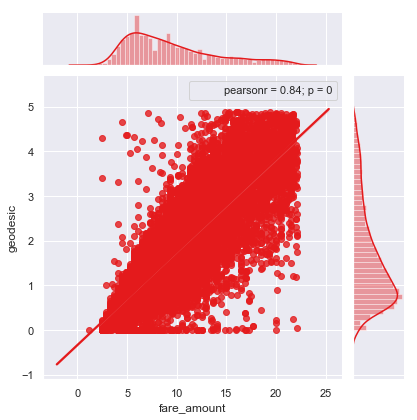

In [188]:
_ = sns.jointplot(x='fare_amount',y='geodesic',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointct.png')
plt.show()

## Feature Scaling Check with or without normalization of standarscalar

In [46]:
train[num_var].var()

fare_amount    20.044364
geodesic        1.204608
dtype: float64

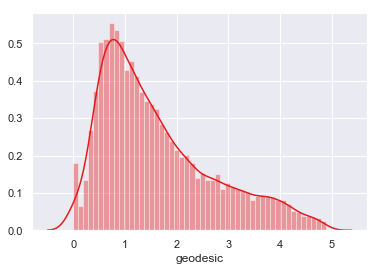

In [53]:
sns.distplot(train['geodesic'],bins=50)

((array([-3.92007182, -3.70085568, -3.58076887, ...,  3.58076887,
          3.70085568,  3.92007182]),
  array([0.        , 0.        , 0.        , ..., 4.88300333, 4.88468361,
         4.88875044])),
 (1.0513960924441437, 1.6213726643867186, 0.957753760202082))

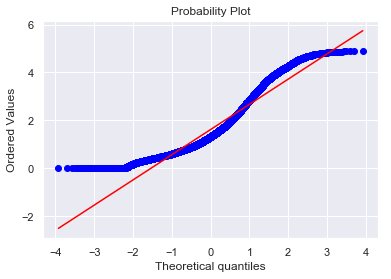

In [59]:
plt.figure()
stats.probplot(train['geodesic'], dist='norm', fit=True,plot=plt)

In [79]:
#Normalization
train['geodesic'] = (train['geodesic'] - min(train['geodesic']))/(max(train['geodesic']) - min(train['geodesic']))
test['geodesic'] = (test['geodesic'] - min(test['geodesic']))/(max(test['geodesic']) - min(test['geodesic']))

In [38]:
train['geodesic'].var()

0.05040223902022794

In [198]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'week_weekend',
       'session_evening', 'session_morning', 'session_night_AM',
       'session_night_PM', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [199]:
df4=train.copy()
# train=df.copy()
f4=test.copy()
# test=f4.copy

In [201]:
# train=train.drop(['passenger_count_2'],axis=1)
# test=test.drop(['passenger_count_2'],axis=1)

In [202]:
train.columns

Index(['fare_amount', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'season_spring',
       'season_summer', 'season_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'geodesic'],
      dtype='object')

## Splitting train into train and validation subsets
- X_train y_train--are train subset
- X_test y_test--are validation subset

In [205]:
X = train.drop('fare_amount',axis=1).values
y = train['fare_amount'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print(train.shape, X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(15660, 20) (11745, 19) (3915, 19) (11745,) (3915,)


In [190]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))

## Multiple Linear Regression

In [191]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': True}
Best score is 0.7354470072210966


R^2: 0.7419533514082807
Root Mean Squared Error: 2.3002058018741725
<<<------------------- Training Data Score --------------------->

r square   0.734319204220999
Adjusted r square:0.7338659787078994
MAPE:18.735715923224962
MSE: 5.284213800261883
RMSE: 2.2987417863391886
RMSLE: 0.21659716896690118

<<<------------------- Test Data Score --------------------->

r square   0.7419533514082807
Adjusted r square:0.7406279962537263
MAPE:18.96393017971928
MSE: 5.290946730975605
RMSE: 2.3002058018741725
RMSLE: 0.2155009683479824
[-2.15901609e-03  1.53984418e-01  2.24104838e-01  2.37076858e-01
  2.17755210e-01 -4.37381253e-01 -4.40442782e-01 -4.71250421e-01
 -2.05177113e-01 -4.00443302e-01 -4.55031796e-01 -6.74705919e-01
 -7.89355852e-01 -7.91809311e-02 -1.35632684e-02  4.34350762e-01
  1.28753808e+00  1.50723934e+00  1.74327896e+00  3.42140813e+00]


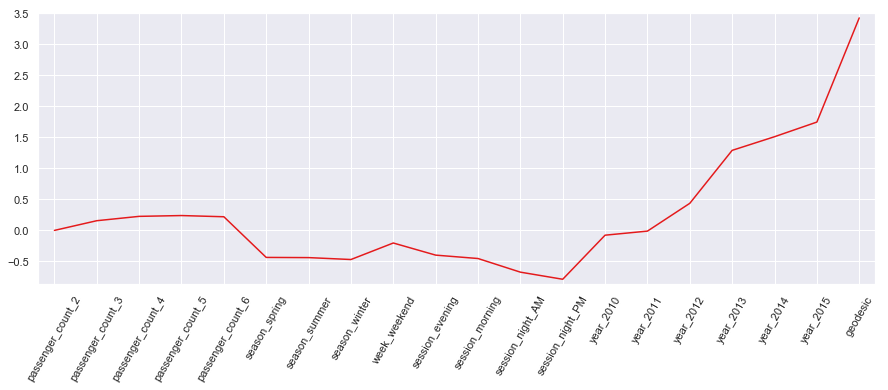

In [192]:
# Create the regressor: reg_all
reg_all = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
reg_coef = reg_all.coef_
print(reg_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), reg_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()

In [193]:
from sklearn.model_selection import cross_val_score
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.30945311 -5.33924713 -5.10740884 -5.30298879 -5.42849547]
Average 5-Fold CV Score: -5.297518668356715


## Ridge Regression

In [194]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2')

# Fit it to the data
ridge_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 1.0, 'max_iter': 500, 'normalize': False}
Best score is 0.7354476552180997


[ 0.15387316  0.22340952  0.23684212  0.21779082 -0.43638877 -0.43957276
 -0.47031104 -0.20508726 -0.39942028 -0.45391591 -0.67319652 -0.78802004
 -0.08192174 -0.01634481  0.43133468  1.2841239   1.5036218   1.73815966
  3.42112111]


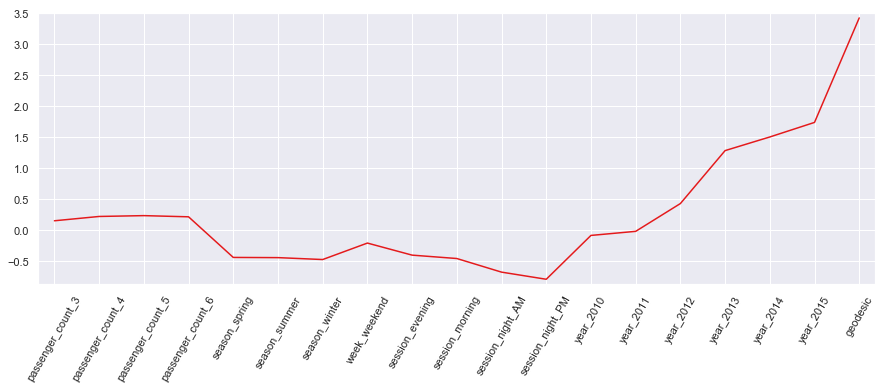

<<<------------------- Training Data Score --------------------->

r square   0.7343190666626476
Adjusted r square:0.7338885389241905
MAPE:18.73576508093349
MSE: 5.2842165362057285
RMSE: 2.2987423814350594
RMSLE: 0.21658486817705955

<<<------------------- Test Data Score --------------------->

r square   0.7419544405493077
Adjusted r square:0.7406956817227189
MAPE:18.964219272914416
MSE: 5.290924399404209
RMSE: 2.3002009476139706
RMSLE: 0.21549228303745274


In [208]:
# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=1, normalize=False,max_iter = 500)

# Fit the regressor to the data
ridge.fit(X_train,y_train)

# Compute and print the coefficients
ridge_coef = ridge.coef_
print(ridge_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), ridge_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
# plt.savefig('ridge coefficients')
plt.show()
test_scores(ridge)

lasso can be used feature selection

## Lasso Regression

In [206]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision lasso classifier: lasso
lasso = Lasso()

# Instantiate the gridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_dist, cv=5,scoring='r2')

# Fit it to the data
lasso_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision lasso Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

Tuned Decision lasso Parameters: {'alpha': 0.0002559547922699536, 'max_iter': 500, 'normalize': False}
Best score is 0.7354763263593402


[ 0.1132627   0.10365676  0.12718744  0.0946751  -0.37468104 -0.39228388
 -0.4277312  -0.18895223 -0.35320169 -0.45076773 -0.67194792 -0.7479393
 -0.04675907 -0.02364529  0.47025935  1.32001331  1.51159484  1.77969165
  3.41987222]
<<<------------------- Training Data Score --------------------->

r square   0.7341845591570211
Adjusted r square:0.7337538134533097
MAPE:18.753929334180754
MSE: 5.286891800766671
RMSE: 2.2993242052321965
RMSLE: 0.2165658995677342

<<<------------------- Test Data Score --------------------->

r square   0.742805078792715
Adjusted r square:0.741550469420972
MAPE:18.95538958139658
MSE: 5.273483050493999
RMSE: 2.296406551657175
RMSLE: 0.21510949162868964


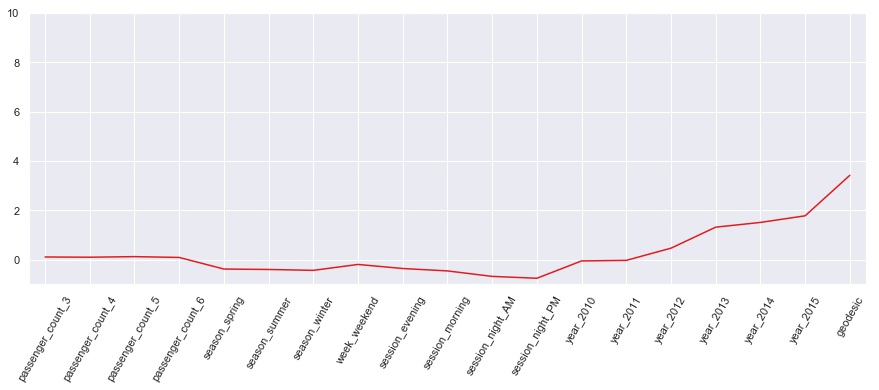

In [207]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.0002559547922699536, normalize=False,max_iter = 500)

# Fit the regressor to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.ylim(-1,10)
plt.plot(range(len(test.columns)), lasso_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
# plt.show()
test_scores(lasso)

## Decision Tree Regression

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15660
Data columns (total 7 columns):
fare_amount        15660 non-null float64
passenger_count    15660 non-null category
year               15660 non-null category
month              15660 non-null category
day_of_week        15660 non-null category
hour               15660 non-null category
geodesic           15660 non-null float64
dtypes: category(5), float64(2)
memory usage: 445.7 KB


In [209]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 6, 'min_samples_split': 2}
Best score is 0.7305546103616307


[2.84435163e-04 0.00000000e+00 0.00000000e+00 6.62460892e-04
 1.59620998e-04 0.00000000e+00 7.12379000e-04 1.20749594e-03
 3.70471248e-04 0.00000000e+00 0.00000000e+00 1.46793390e-04
 6.34678886e-04 0.00000000e+00 0.00000000e+00 1.12129914e-02
 1.18937766e-02 1.10197544e-02 9.61695142e-01]


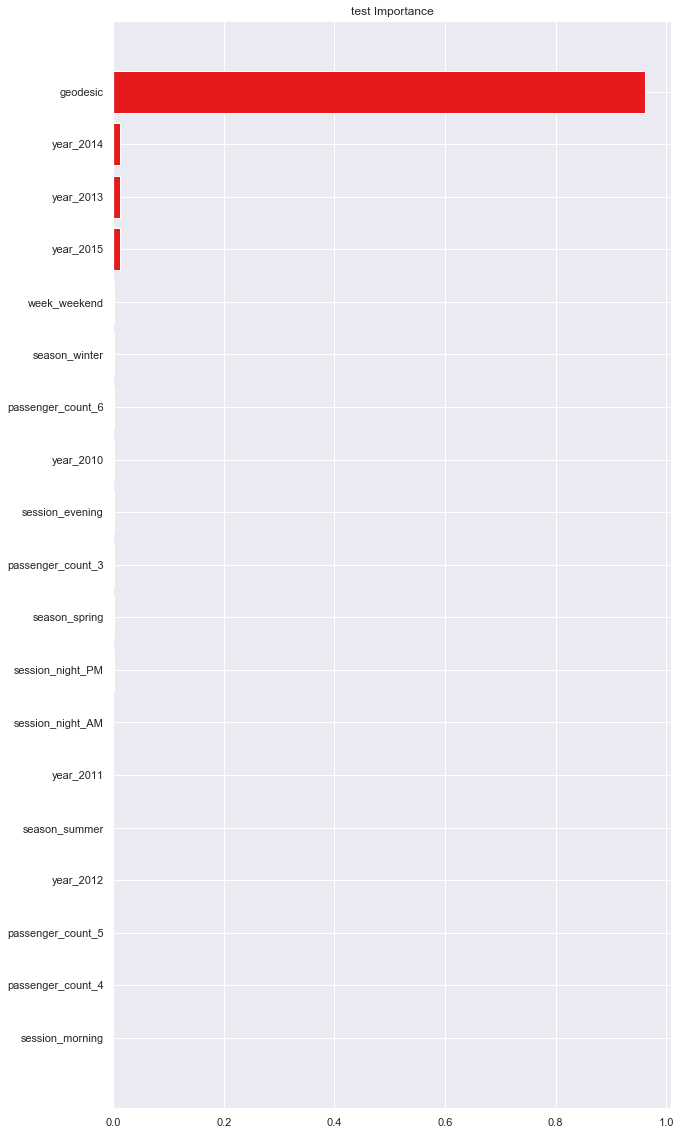

<<<------------------- Training Data Score --------------------->

r square   0.7471717721101269
Adjusted r square:0.7467620717834822
MAPE:18.547596834180297
MSE: 5.028584798514138
RMSE: 2.2424506234283372
RMSLE: 0.208707647677473

<<<------------------- Test Data Score --------------------->

r square   0.7408908559451675
Adjusted r square:0.7396269089009975
MAPE:19.073259913895583
MSE: 5.312731966040331
RMSE: 2.30493643427326
RMSLE: 0.2123419225641147


In [212]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=2)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(10,20))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
# plt.savefig('tree test importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

## Random Forest Regression

In [213]:
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 12, 'bootstrap': True}
Best score is 0.7424850700261258


[1.10315738e-03 5.97085961e-04 1.24921891e-03 5.12249894e-04
 4.71687506e-03 4.54310180e-03 4.11621285e-03 5.42731029e-03
 4.16241859e-03 3.97232886e-03 3.45444923e-03 5.08340701e-03
 3.56998401e-03 1.59897275e-03 2.81160656e-03 1.05884370e-02
 1.21170848e-02 9.42367976e-03 9.20952419e-01]


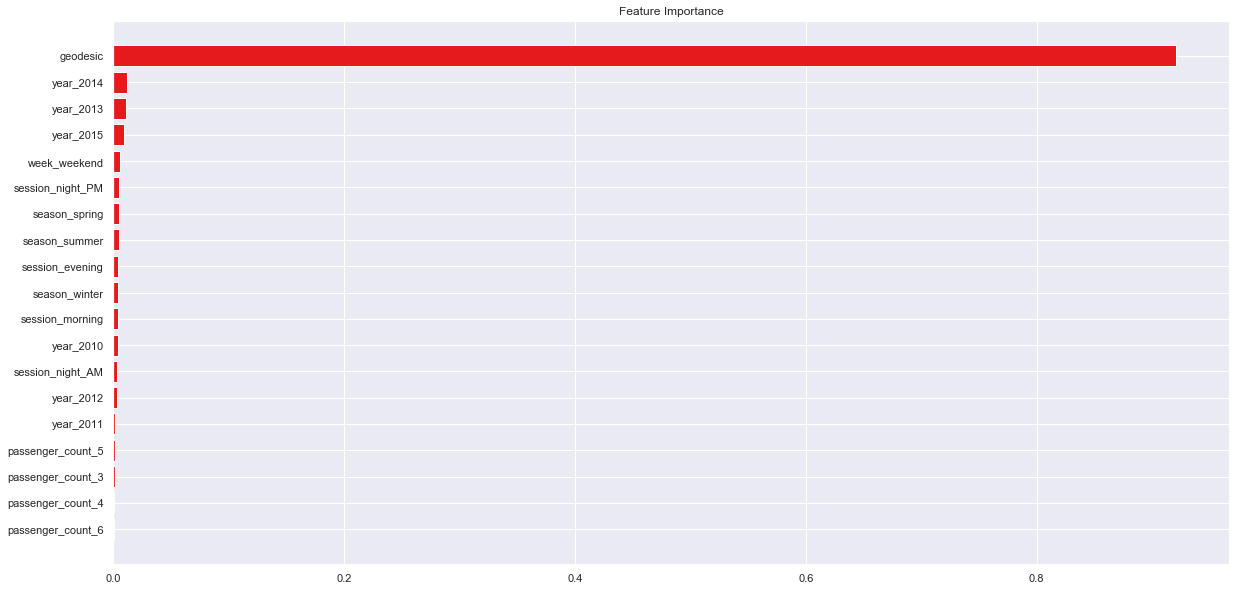

<<<------------------- Training Data Score --------------------->

r square   0.8225728614726506
Adjusted r square:0.8222853462801543
MAPE:15.544050073206348
MSE: 3.5289074289249003
RMSE: 1.8785386418503347
RMSLE: 0.1759310294687283

<<<------------------- Test Data Score --------------------->

r square   0.7525012744442805
Adjusted r square:0.7512939635879111
MAPE:18.63384772625153
MSE: 5.074673823691288
RMSE: 2.2527036697469307
RMSLE: 0.20806929727452894


In [214]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=400, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=12, bootstrap=True)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
# plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

In [227]:
from sklearn.model_selection import cross_val_score
# Create a linear regression object: reg
Forest = RandomForestRegressor(n_estimators=400, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=12, bootstrap=True)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(Forest,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.19664082 -5.18179823 -5.12593482 -5.14346743 -5.14329614]
Average 5-Fold CV Score: -5.158227488283968


## Improving accuracy using XGBOOST
- Improve Accuracy a) Algorithm Tuning b) Ensembles

In [217]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [218]:
dtrain,dtest,data_dmatrix

(<xgboost.core.DMatrix at 0x1d381734278>,
 <xgboost.core.DMatrix at 0x1d381734240>)

In [219]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.178985,0.026091,9.179045,0.057263
1,8.432683,0.059984,8.433982,0.122851
2,7.774301,0.132268,7.777495,0.194230
3,7.074266,0.118090,7.078735,0.179167
4,6.598351,0.127021,6.602908,0.189291


In [220]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

49    2.658377
Name: test-rmse-mean, dtype: float64


In [222]:
Xgb = XGBRegressor()
Xgb.fit(X_train,y_train)
# pred_xgb = model_xgb.predict(X_test)
test_scores(Xgb)

<<<------------------- Training Data Score --------------------->

r square   0.761287047362023
Adjusted r square:0.7609002204025244
MAPE:17.819060513514806
MSE: 4.74784138963558
RMSE: 2.1789541963142733
RMSLE: 0.20102748810519094

<<<------------------- Test Data Score --------------------->

r square   0.7597945263108389
Adjusted r square:0.758622792292843
MAPE:18.261871387666925
MSE: 4.92513416746191
RMSE: 2.2192643302369164
RMSLE: 0.20453982549321043


In [223]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

# Fit it to the data
xgb_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))


Tuned Xgboost Parameters: {'subsample': 0.1, 'reg_alpha': 0.08685113737513521, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.7000000000000001, 'colsample_bylevel': 0.9000000000000001}
Best score is 0.7488462384005503


[0.01725235 0.0177566  0.01611731 0.02142689 0.0239779  0.02705638
 0.01754795 0.01853316 0.02070088 0.01528554 0.02937558 0.01964421
 0.03303751 0.02154694 0.01814925 0.04862025 0.05184225 0.0367777
 0.5453513 ]


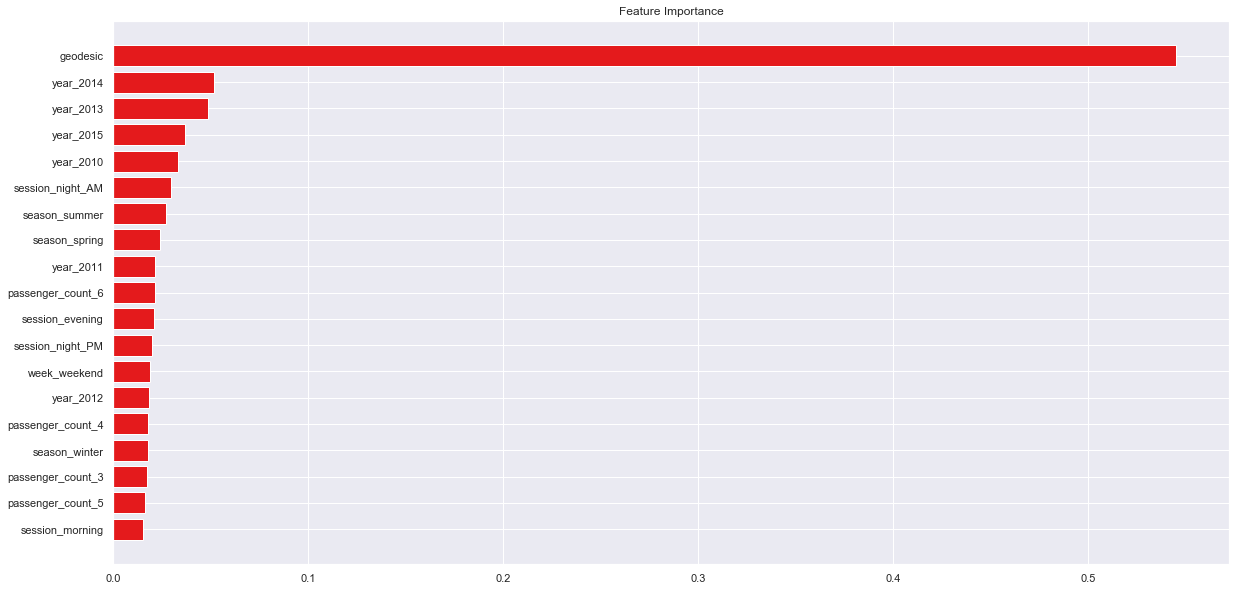

<<<------------------- Training Data Score --------------------->

r square   0.7541021724011799
Adjusted r square:0.7537037025739409
MAPE:18.165083810668126
MSE: 4.890743759789666
RMSE: 2.2115026022570414
RMSLE: 0.204838222434575

<<<------------------- Test Data Score --------------------->

r square   0.7585621183957287
Adjusted r square:0.7573843726318055
MAPE:18.373913959881204
MSE: 4.9504032599506775
RMSE: 2.224950170217454
RMSLE: 0.20538183421499542


In [226]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X_train,y_train)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
# plt.savefig('Random xgb feature importance')
plt.show()# Make predictions
test_scores(Xgb)

## Finalize model
- Create standalone model on entire training dataset
- Save model for later use

In [228]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def score(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_)))
    print('RMSLE:',rmsle(y_test,y_pred))
def scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X)
    score(y,y_pred)
    print('RMSLE:',rmsle(y,y_pred))   

In [229]:
test.columns

Index(['passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_spring', 'season_summer', 'season_winter',
       'week_weekend', 'session_evening', 'session_morning',
       'session_night_AM', 'session_night_PM', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [230]:
train.columns

Index(['fare_amount', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'season_spring',
       'season_summer', 'season_winter', 'week_weekend', 'session_evening',
       'session_morning', 'session_night_AM', 'session_night_PM', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'geodesic'],
      dtype='object')

In [ ]:
a=pd.read_csv('test.csv')

In [233]:
test_pickup_datetime=a['pickup_datetime']

[0.0141651  0.01900789 0.01221532 0.01406857 0.01698018 0.0207128
 0.01611503 0.01987083 0.0143042  0.02311991 0.02906197 0.02030098
 0.02589433 0.02589435 0.02103971 0.04098737 0.0488467  0.03911658
 0.5782982 ]


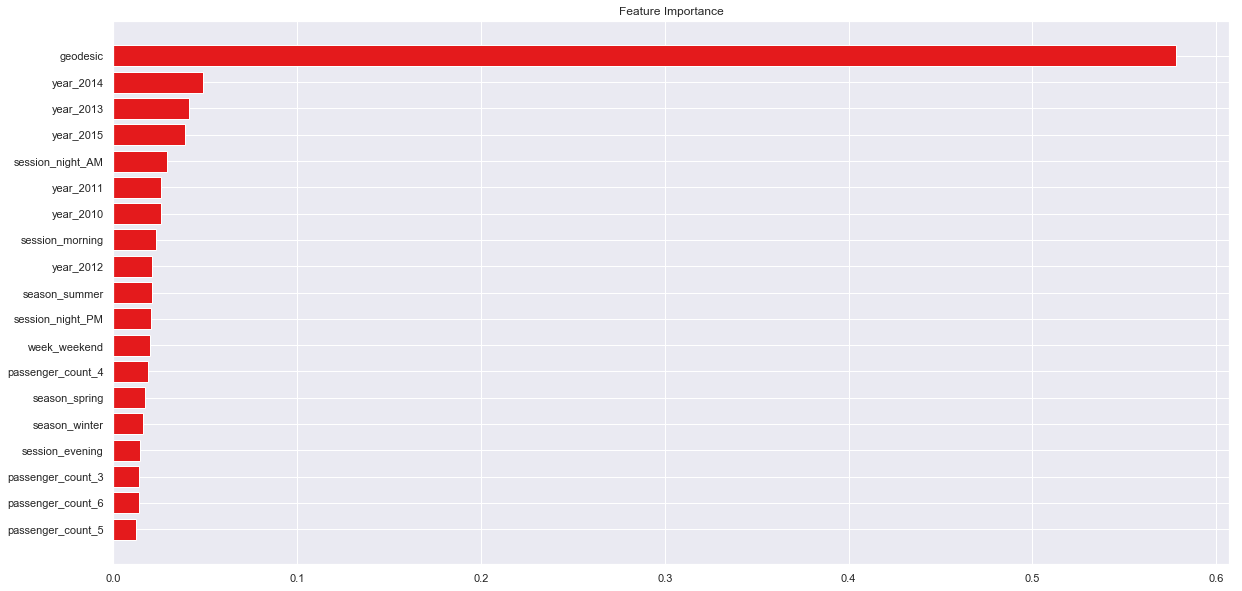

<<<------------------- Training Data Score --------------------->

r square   0.7563787992076898
Adjusted r square:0.7560828399484152
MAPE:18.109261900474564
MSE: 4.882920272779055
RMSE: 2.209733077269527
RMSLE: 0.2155009683479824
RMSLE: 0.20420628566517265


In [235]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X,y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
# plt.savefig(' xgb feature importance')
plt.show()
scores(Xgb)

# Predictions
pred = Xgb.predict(test.values)
pred_results_wrt_date = pd.DataFrame({"pickup_datetime":test_pickup_datetime,"fare_amount" : pred})
# pred_results_wrt_fullcsv= 
# pred_results.to_csv("predictions_xgboost.csv",index=False)

In [236]:
pred_results_wrt_date

,pickup_datetime,prediction
0,2015-01-27 13:08:24 UTC,10.346493
1,2015-01-27 13:08:24 UTC,10.847954
2,2011-10-08 11:53:44 UTC,4.352736
3,2012-12-01 21:12:12 UTC,7.438527
4,2012-12-01 21:12:12 UTC,15.103196
5,2012-12-01 21:12:12 UTC,10.278064
6,2011-10-06 12:10:20 UTC,5.358164
7,2011-10-06 12:10:20 UTC,15.853908
8,2011-10-06 12:10:20 UTC,11.389716
9,2014-02-18 15:22:20 UTC,6.736518


In [ ]:
# Save the model as a pickle in a file 
joblib.dump(knn, 'cab_fare_xgboost_model.pkl') 
  
# # Load the model from the file 
# Xgb_from_joblib = joblib.load('cab_fare_xgboost_model.pkl')  

https://www.kaggle.com/dhrubajitdas/model-comparison-accuracyscore-rmse

https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/regression/supporting-topics/model-assumptions/validate-model-assumptions/